In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers,Input,optimizers

In [3]:

googlel = pd.read_csv("GOOGL.csv")

def paint(data):
    data = data.iloc[::-1]
    data = data.reset_index(drop=True)
    #data['Label'] = np.where(data['adj close'].shift(-1) > data['adj close'], 1, 0)
    #data['Label'] = (data['close'] > data['open']).astype(int)
    return data

googlel = paint(googlel)


tweets = pd.read_csv("D:\johnny的文件夹\FDU 课程\大二下\大数据商务分析\Final project\data\Tweet\Tweet.csv")
company_tweets = pd.read_csv(
    "D:\johnny的文件夹\FDU 课程\大二下\大数据商务分析\Final project\data\Tweet\Company_Tweet.csv")
tweets.drop('writer', axis=1, inplace=True)
df_tweets = pd.merge(tweets, company_tweets, on='tweet_id', how='left')
df_tweets['post_date'] = pd.to_datetime(df_tweets['post_date'], unit='s')
df_tweets['post_date'] = df_tweets['post_date'].dt.strftime('%Y-%m-%d')
df_tweets.drop('tweet_id', axis=1, inplace=True)
df_tweets['tweet_score'] = 1 * df_tweets['comment_num'] + 1 * df_tweets['retweet_num'] + 1.2 * df_tweets['like_num']
df_tweets = df_tweets[df_tweets['tweet_score'] >= 50].reset_index()
df_tweets.drop('index', axis=1, inplace=True)
df_tweets.drop('comment_num', axis=1, inplace=True)
df_tweets.drop('retweet_num', axis=1, inplace=True)
df_tweets.drop('like_num', axis=1, inplace=True)

df_tweets.rename(columns={'post_date': 'date'}, inplace=True)
df_tweets['date'] = pd.to_datetime(df_tweets['date'])

def explore(df, company):
    df1 = df[df['ticker_symbol'] == company]
    score = df1.groupby('date')['tweet_score'].sum()
    df1 = pd.concat([score], axis=1)
    df1 = df1.reset_index()
    return df1
googlel_tweets = explore(df_tweets, 'GOOGL')


def make_stock(stock, tweet):
    stock['date'] = pd.to_datetime(stock['date'])
    tweet['date'] = pd.to_datetime(tweet['date'])

    start_date = '2015-01-01'
    end_date = '2019-12-31'
    stock = stock.loc[(stock['date'] >= start_date) & (stock['date'] <= end_date)]
    result = pd.merge(stock, tweet, on='date', how='left')
    return result
googlel = make_stock(googlel, googlel_tweets).dropna()


In [4]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

df=pd.DataFrame(googlel,columns=['date','open','close','tweet_score'])
data = df[['open','close','tweet_score']].values
# 归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(scaled_data)

# 创建数据集
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, :2])  
    return np.array(X), np.array(y)

time_step = 100
X, y = create_dataset(scaled_data, time_step)

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


[[0.         0.         0.00784973]
 [0.02726354 0.0064519  0.0320998 ]
 [0.03808076 0.0295596  0.01422764]
 ...
 [1.         0.98685072 0.065321  ]
 [0.98079141 1.         0.02593216]
 [0.99269964 0.97339753 0.04289319]]


In [5]:
# 创建LSTM模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 3)))  # 输入形状为(time_step, 2)
model.add(LSTM(units=50))
model.add(Dense(2))  # 输出一个值，即预测的closing价格

model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反归一化
train_predict_full = np.concatenate((train_predict, np.zeros((train_predict.shape[0], 1))), axis=1)
test_predict_full = np.concatenate((test_predict, np.zeros((test_predict.shape[0], 1))), axis=1)
train_predict = scaler.inverse_transform(train_predict_full)[:, :2]
test_predict = scaler.inverse_transform(test_predict_full)[:, :2]


Epoch 1/40


C:\Users\johnn\PycharmProjects\Deep Learning\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.2177 - val_loss: 0.0079
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0087 - val_loss: 0.0120
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0043 - val_loss: 0.0102
Epoch 4/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0037 - val_loss: 0.0053
Epoch 5/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0030 - val_loss: 0.0070
Epoch 6/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0025 - val_loss: 0.0050
Epoch 7/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0022 - val_loss: 0.0042
Epoch 8/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 9/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 10/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 11/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 12/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0020 - val_l

In [6]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_test, test_predict)
print(train_mse, test_mse)
# accuracy, mse
# 相对于原始数据的涨跌

1101440.588021034 1454747.8656314453


In [7]:
open_predict = np.concatenate([train_predict[:,0], test_predict[:,0]], axis=0)
close_predict = np.concatenate([train_predict[:,1], test_predict[:,1]], axis=0)


In [8]:
open_predict.shape

(565,)

Text(0.5, 1.0, 'Stock Price Prediction')

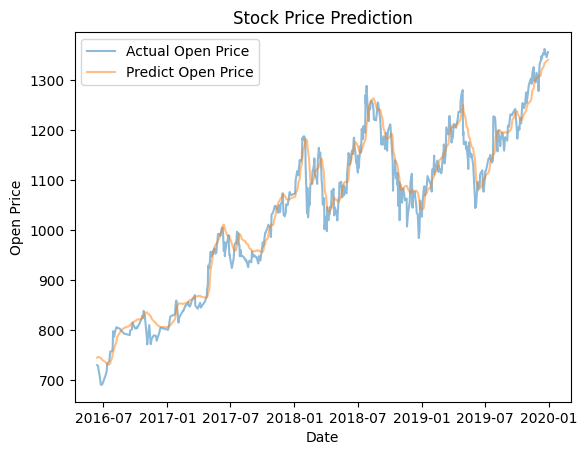

In [9]:
import matplotlib.pyplot as plt
plt.plot(df['date'][time_step:], df['open'][time_step:], label='Actual Open Price', alpha=0.5)
plt.plot(df['date'][time_step:], open_predict, label='Predict Open Price', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Stock Price Prediction')

Text(0.5, 1.0, 'Stock Price Prediction')

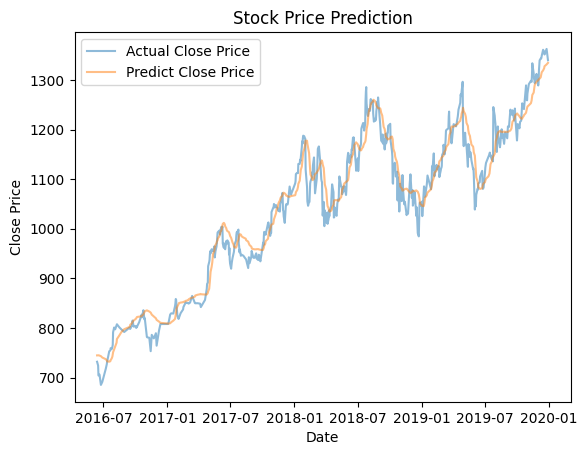

In [10]:
plt.plot(df['date'][time_step:], df['close'][time_step:], label='Actual Close Price', alpha=0.5)
plt.plot(df['date'][time_step:], close_predict, label='Predict Close Price', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction')

In [11]:
prediction = pd.DataFrame({'pre_open':open_predict, 'pre_close':close_predict})
prediction

,pre_open,pre_close
0,744.918084,744.733056
1,745.683476,744.856898
2,746.124305,744.917659
3,745.553933,744.357551
4,743.975159,743.157656
...,...,...
560,1325.781239,1319.157684
561,1330.551840,1323.476888
562,1334.784756,1327.487876
563,1338.594817,1331.195136


In [12]:
googlel.reset_index(inplace=True)
googlel_stock = pd.concat([googlel, prediction], axis=1)
googlel_stock

,index,date,open,high,low,close,adj close,volume,tweet_score,pre_open,pre_close
0,4,2015-01-08,501.510010,507.500000,495.019989,506.910004,506.910004,3652700,72.4,744.918084,744.733056
1,17,2015-01-28,525.000000,525.690002,512.349976,512.429993,512.429993,1791100,141.6,745.683476,744.856898
2,20,2015-02-02,534.320007,536.500000,521.719971,532.200012,532.200012,3768900,90.6,746.124305,744.917659
3,36,2015-02-25,538.440002,549.570007,538.010010,547.330017,547.330017,2041800,54.6,745.553933,744.357551
4,40,2015-03-03,576.349976,580.849976,570.500000,578.789978,578.789978,2526300,54.4,743.975159,743.157656
...,...,...,...,...,...,...,...,...,...,...,...
660,1247,2019-12-16,1355.000000,1363.530029,1350.609985,1360.699951,1360.699951,1406400,66.8,NaN,NaN
661,1250,2019-12-19,1351.910034,1357.530029,1348.750000,1356.439941,1356.439941,1446100,81.8,NaN,NaN
662,1251,2019-12-20,1363.099976,1364.000000,1350.729980,1351.219971,1351.219971,2504500,236.4,NaN,NaN
663,1254,2019-12-26,1346.550049,1363.199951,1345.510010,1362.469971,1362.469971,1183100,124.0,NaN,NaN


In [13]:
googlel_stock['pre_Label'] = np.where(googlel_stock['pre_close'].shift(-1) > googlel_stock['pre_close'], 1, 0)
googlel_stock['Label'] = np.where(googlel_stock['close'].shift(-1) > googlel_stock['close'], 1, 0)
googlel_stock.dropna(inplace=True)

In [14]:
googlel_stock

,index,date,open,high,low,close,adj close,volume,tweet_score,pre_open,pre_close,pre_Label,Label
0,4,2015-01-08,501.510010,507.500000,495.019989,506.910004,506.910004,3652700,72.4,744.918084,744.733056,1,1
1,17,2015-01-28,525.000000,525.690002,512.349976,512.429993,512.429993,1791100,141.6,745.683476,744.856898,1,1
2,20,2015-02-02,534.320007,536.500000,521.719971,532.200012,532.200012,3768900,90.6,746.124305,744.917659,0,1
3,36,2015-02-25,538.440002,549.570007,538.010010,547.330017,547.330017,2041800,54.6,745.553933,744.357551,0,1
4,40,2015-03-03,576.349976,580.849976,570.500000,578.789978,578.789978,2526300,54.4,743.975159,743.157656,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,1098,2019-05-15,1122.550049,1178.300049,1121.400024,1170.800049,1170.800049,2965100,55.0,1325.781239,1319.157684,1,0
561,1100,2019-05-17,1175.829956,1186.290039,1166.420044,1168.780029,1168.780029,1268100,60.4,1330.551840,1323.476888,1,0
562,1101,2019-05-20,1153.000000,1153.000000,1138.140015,1144.660034,1144.660034,1530100,487.6,1334.784756,1327.487876,1,1
563,1102,2019-05-21,1154.479980,1158.000000,1143.310059,1154.439941,1154.439941,1028100,974.4,1338.594817,1331.195136,1,0


In [15]:
TP = ((googlel_stock['Label'] == 1) & (googlel_stock['pre_Label'] == 1)).sum()
FP = ((googlel_stock['Label'] == 0) & (googlel_stock['pre_Label'] == 1)).sum()
FN = ((googlel_stock['Label'] == 1) & (googlel_stock['pre_Label'] == 0)).sum()

# 计算 Precision 和 Recall
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall)
print(precision, recall, f1)

0.5662983425414365 0.6591639871382636 0.6092124814264487


In [16]:
initial_fund = 10000
funds = initial_fund
for index in range(len(googlel_stock) - 1):
    if googlel_stock.loc[index, 'pre_Label'] == 1:
        # 在下一行的open买入股票
        funds += (googlel_stock.loc[index + 1, 'close'] - googlel_stock.loc[index + 1, 'open'])
print(funds)

10164.210510253906


In [17]:
X = []
y = []
for i in range(len(scaled_data)-100-7+1):
    X.append(scaled_data[i:i+100])
    y.append(scaled_data[i+100+7-1, 1])  
X = np.array(X)
y = np.array(y)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(100, 3)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=40, batch_size=32,validation_data=(X_test, y_test))
predictions = []
for i in range(len(X) - split):
    predictions.append(model.predict(np.expand_dims(X[split+i], axis=0))[0, 0])
predictions = scaler.inverse_transform([[0, pred, 0] for pred in predictions])[:, 1]
print(predictions)

C:\Users\johnn\PycharmProjects\Deep Learning\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.2829 - val_loss: 0.0059
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0107 - val_loss: 0.0114
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0049 - val_loss: 0.0084
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0041 - val_loss: 0.0078
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0035 - val_loss: 0.0075
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0036 - val_loss: 0.0069
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0033 - val_loss: 0.0062
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0032 - val_loss: 0.0074
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0032 - val_loss: 0.0061
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0034 - val_loss: 0.0061
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0034 - val_loss: 0.0050
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0

In [18]:
predictions = pd.DataFrame(predictions, columns=['pred'])
num = len(googlel) - len(predictions)
df = googlel[num:]
df.reset_index(inplace=True)
stock1 = pd.concat([df, predictions], axis=1)
stock1['pre_Label'] = np.where(stock1['pred'].shift(-1) > stock1['pred'], 1, 0)
stock1['Label'] = np.where(stock1['close'].shift(-1) > stock1['close'], 1, 0)
TP = ((stock1['Label'] == 1) & (stock1['pre_Label'] == 1)).sum()
FP = ((stock1['Label'] == 0) & (stock1['pre_Label'] == 1)).sum()
FN = ((stock1['Label'] == 1) & (stock1['pre_Label'] == 0)).sum()

# 计算 Precision 和 Recall
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall)
print(round(precision,3), round(recall,3), round(f1,3))

0.544 0.627 0.583
